In [49]:
import os
import numpy as np
import torch
import torchaudio
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import random
import time
import warnings
warnings.filterwarnings('ignore')

# Set seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed()

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create directories
os.makedirs('checkpoints', exist_ok=True)

Using device: cuda


In [50]:
# Load data
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")

# Define emotion mapping
emotion_mapping = {
    "marah": 0,
    "jijik": 1,
    "takut": 2,
    "bahagia": 3, 
    "netral": 4,
    "sedih": 5
}

# Split into train/val
train_data, val_data = train_test_split(
    train_df, test_size=0.15, random_state=42, stratify=train_df['label']
)

print(f"Training data: {len(train_data)} samples")
print(f"Validation data: {len(val_data)} samples")
print(f"Test data: {len(test_df)} samples")

Training data shape: (6798, 2)
Test data shape: (1700, 1)
Training data: 5778 samples
Validation data: 1020 samples
Test data: 1700 samples


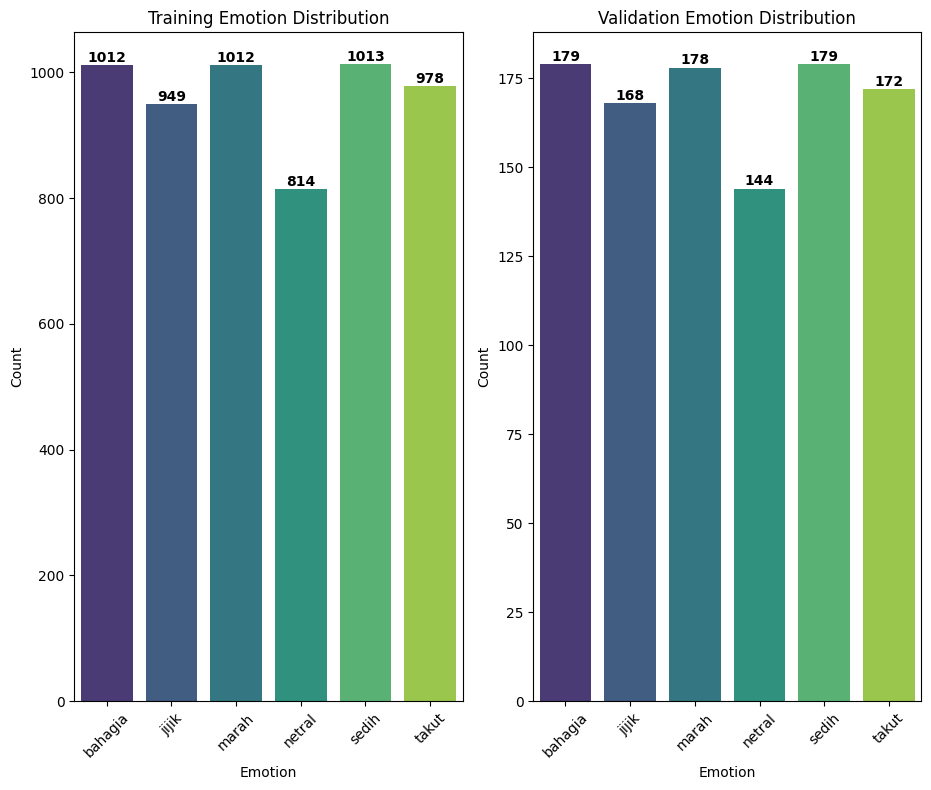

Emotion Distribution:

Training Dataset:
bahagia: 1012 samples (17.51%)
jijik: 949 samples (16.42%)
marah: 1012 samples (17.51%)
netral: 814 samples (14.09%)
sedih: 1013 samples (17.53%)
takut: 978 samples (16.93%)

Validation Dataset:
bahagia: 179 samples (17.55%)
jijik: 168 samples (16.47%)
marah: 178 samples (17.45%)
netral: 144 samples (14.12%)
sedih: 179 samples (17.55%)
takut: 172 samples (16.86%)


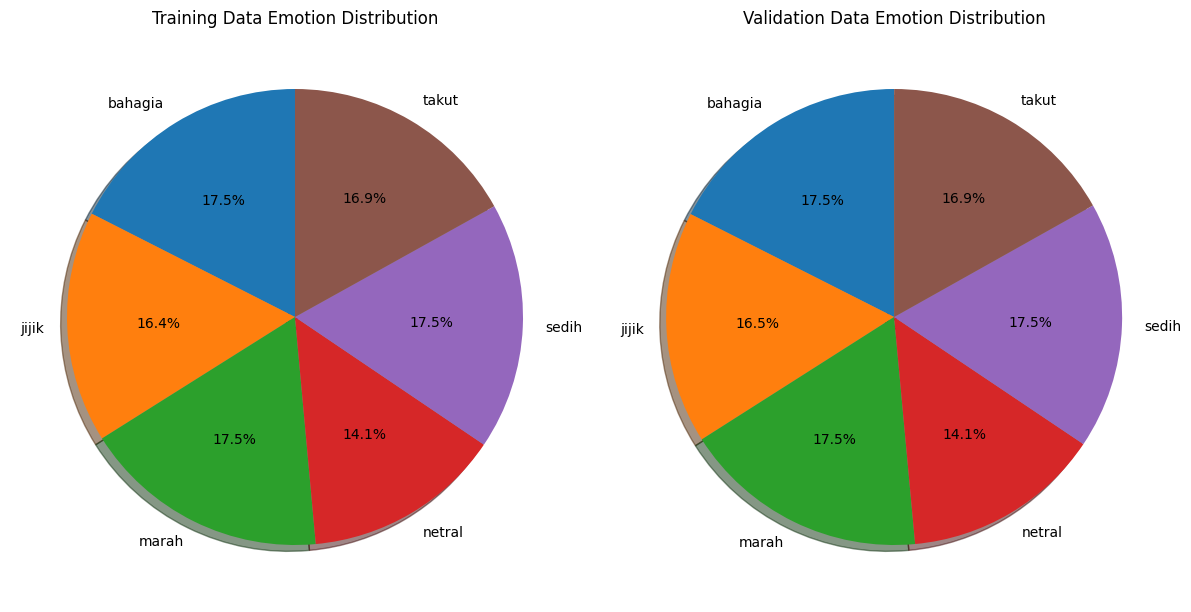

In [51]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import traceback
import warnings

# Count the emotion distributions
train_dist = train_data['label'].value_counts().sort_index()
val_dist = val_data['label'].value_counts().sort_index()

# If test_df contains labels
if 'label' in test_df.columns:
    test_dist = test_df['label'].value_counts().sort_index()
    has_test_labels = True
else:
    has_test_labels = False

# Set up the figure
plt.figure(figsize=(14, 8))

# Create bar plot for emotion distribution
def plot_distribution():
    # Plot training distribution
    ax1 = plt.subplot(1, 3, 1)
    sns.barplot(x=train_dist.index, y=train_dist.values, palette='viridis')
    plt.title('Training Emotion Distribution')
    plt.xlabel('Emotion')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    
    # Add count labels on the bars
    for i, count in enumerate(train_dist.values):
        plt.text(i, count + 5, str(count), ha='center', fontweight='bold')

    # Plot validation distribution
    ax2 = plt.subplot(1, 3, 2)
    sns.barplot(x=val_dist.index, y=val_dist.values, palette='viridis')
    plt.title('Validation Emotion Distribution')
    plt.xlabel('Emotion')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    
    # Add count labels on the bars
    for i, count in enumerate(val_dist.values):
        plt.text(i, count + 1, str(count), ha='center', fontweight='bold')
    
    # Plot test distribution if labels are available
    if has_test_labels:
        ax3 = plt.subplot(1, 3, 3)
        sns.barplot(x=test_dist.index, y=test_dist.values, palette='viridis')
        plt.title('Test Emotion Distribution')
        plt.xlabel('Emotion')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        
        # Add count labels on the bars
        for i, count in enumerate(test_dist.values):
            plt.text(i, count + 1, str(count), ha='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# For a more detailed analysis, we can also print percentages
def print_distribution_stats():
    print("Emotion Distribution:")
    print("\nTraining Dataset:")
    train_percent = (train_dist / train_dist.sum() * 100).round(2)
    for emotion, count in zip(train_dist.index, train_dist.values):
        print(f"{emotion}: {count} samples ({train_percent[emotion]}%)")
    
    print("\nValidation Dataset:")
    val_percent = (val_dist / val_dist.sum() * 100).round(2)
    for emotion, count in zip(val_dist.index, val_dist.values):
        print(f"{emotion}: {count} samples ({val_percent[emotion]}%)")
    
    if has_test_labels:
        print("\nTest Dataset:")
        test_percent = (test_dist / test_dist.sum() * 100).round(2)
        for emotion, count in zip(test_dist.index, test_dist.values):
            print(f"{emotion}: {count} samples ({test_percent[emotion]}%)")

# Plot the distributions
plot_distribution()

# Print statistics
print_distribution_stats()

# Create a pie chart visualization for another perspective
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.pie(train_dist.values, labels=train_dist.index, autopct='%1.1f%%', startangle=90, shadow=True)
plt.title('Training Data Emotion Distribution')

plt.subplot(1, 3, 2)
plt.pie(val_dist.values, labels=val_dist.index, autopct='%1.1f%%', startangle=90, shadow=True)
plt.title('Validation Data Emotion Distribution')

if has_test_labels:
    plt.subplot(1, 3, 3)
    plt.pie(test_dist.values, labels=test_dist.index, autopct='%1.1f%%', startangle=90, shadow=True)
    plt.title('Test Data Emotion Distribution')

plt.tight_layout()
plt.show()

In [52]:
class EmotionDataset(Dataset):
    def __init__(self, df, base_path, fast_mode=True, use_cache=True):
        self.df = df
        self.base_path = base_path
        self.class2idx = {"marah":0, "jijik":1, "takut":2, "bahagia":3, "netral":4, "sedih":5}
        self.fast_mode = fast_mode
        self.use_cache = use_cache
        self.cache = {}
        
        # Audio preprocessing settings
        self.target_sr = 16000
        self.target_duration = 2.5 if fast_mode else 3.0  # Slightly longer even in fast mode
        
        # Create mel spectrogram transform with improved settings
        if fast_mode:
            self.mel_spec_transform = torchaudio.transforms.MelSpectrogram(
                sample_rate=self.target_sr,
                n_fft=512,       # Increased from 400 for better frequency resolution
                n_mels=64,       # Increased from 32 for better feature representation
                hop_length=256,   # Reduced from 320 for better temporal resolution
                f_min=20,        # Set minimum frequency to focus on speech
                f_max=8000       # Set maximum frequency to focus on speech
            )
        else:
            self.mel_spec_transform = torchaudio.transforms.MelSpectrogram(
                sample_rate=self.target_sr,
                n_fft=1024,      # Increased from 512 for even better resolution
                n_mels=80,       # Increased from 64 for better feature representation
                hop_length=256,
                f_min=20,
                f_max=8000
            )
        
        # Add MFCC transform for additional features
        self.mfcc_transform = torchaudio.transforms.MFCC(
            sample_rate=self.target_sr,
            n_mfcc=13,           # Standard number of MFCCs
            melkwargs={
                'n_fft': 512,
                'n_mels': 40,
                'hop_length': 256
            }
        )
        
        # Add chroma feature instead of spectral contrast
        self.chroma_transform = torchaudio.transforms.Spectrogram(
            n_fft=512, 
            win_length=400,
            hop_length=160
        )

    def __len__(self):
        return len(self.df)
        
    def preemphasis(self, waveform, coef=0.97):
        """Apply pre-emphasis filter to highlight higher frequencies"""
        # Keeping the shape: (1, time)
        result = torch.zeros_like(waveform)
        result[:, 0] = waveform[:, 0]
        result[:, 1:] = waveform[:, 1:] - coef * waveform[:, :-1]
        return result
    
    def normalize_audio(self, waveform):
        """Normalize audio to have zero mean and unit variance"""
        if waveform.numel() > 0 and torch.std(waveform) > 0:
            return (waveform - torch.mean(waveform)) / (torch.std(waveform) + 1e-10)
        return waveform
        
    def vad_trim(self, waveform, top_db=30):
        """Trim silence from audio using Voice Activity Detection"""
        # Skip VAD for extremely short segments
        if waveform.size(1) < 100:
            return waveform
            
        # Get frame-wise energy
        window_size = 200
        energy = torch.square(waveform)
        window_energy = torch.nn.functional.avg_pool1d(
            energy, kernel_size=window_size, stride=1, padding=window_size//2
        )
        
        # Get threshold
        db_threshold = torch.max(window_energy) / (10**(top_db/10))
        
        # Find voiced frames
        voiced = (window_energy > db_threshold).squeeze()
        
        if torch.sum(voiced) < 100:  # If very few voiced frames found
            return waveform  # Return original
            
        # Find start/end of speech
        start = max(0, torch.where(voiced)[0][0] - window_size)
        end = min(waveform.size(1), torch.where(voiced)[0][-1] + window_size)
        
        return waveform[:, start:end]
        
    def compute_pitch_features(self, waveform, num_features=6):
        """Compute pitch-related features as a replacement for spectral contrast"""
        # Get spectrogram
        spec = self.chroma_transform(waveform)
    
        # Ensure correct dimensions for calculations
        spec_dim = spec.shape[1]  # Get the actual frequency dimension size
    
        # Create frequency array matching the exact spectrogram dimensions
        freqs = torch.linspace(0, self.target_sr/2, spec_dim)
    
        # Reshape freqs for broadcasting: [1, freq_dim, 1]
        freqs = freqs.view(1, -1, 1).to(spec.device)
    
        # Compute spectral centroid (center of mass) with proper broadcasting
        centroid = torch.sum(freqs * spec, dim=1) / (torch.sum(spec, dim=1) + 1e-8)
    
        # Compute spectral flux (frame-to-frame spectral difference) safely
        if spec.shape[2] > 1:  # Only if we have more than one time frame
            flux = torch.sqrt(torch.sum(torch.diff(spec, dim=2)**2, dim=1))
        else:
            flux = torch.zeros(spec.shape[0], 1).to(spec.device)
    
        # Get a few frequency bands (simpler version of spectral contrast)
        band_size = max(1, spec_dim // num_features)  # Ensure band_size is at least 1
        bands = []
        for i in range(num_features):
            start_idx = i * band_size
            end_idx = min((i + 1) * band_size, spec_dim)
            if start_idx < end_idx:  # Ensure valid slice
                band_energy = torch.mean(spec[:, start_idx:end_idx, :], dim=1)
                bands.append(band_energy)
            else:
            # Add zeros if we've run out of bands
                bands.append(torch.zeros(spec.shape[0], spec.shape[2]).to(spec.device))
            
        # Stack bands to create feature similar to spectral contrast
        features = torch.stack(bands, dim=1)
    
        # Ensure we have the right number of features
        if features.shape[1] < num_features:
            padding = torch.zeros(features.shape[0], 
                             num_features - features.shape[1], 
                             features.shape[2], 
                             device=features.device)
            features = torch.cat([features, padding], dim=1)
            
        return features

    def __getitem__(self, idx):
        # Get audio path and label
        row = self.df.iloc[idx]
        audio_id = row['id']
        audio_path = f"{self.base_path}/{audio_id}"
        
        # Use cache if available
        if self.use_cache and audio_path in self.cache:
            return self.cache[audio_path]
            
        try:
            # Load audio
            waveform, sample_rate = torchaudio.load(audio_path)
            
            # Convert stereo to mono by averaging channels
            if waveform.shape[0] > 1:
                waveform = waveform.mean(dim=0, keepdim=True)
            
            # Resample to target sample rate if needed
            if sample_rate != self.target_sr:
                waveform = torchaudio.functional.resample(waveform, sample_rate, self.target_sr)
            
            # Process the audio signal for better feature extraction
            waveform = self.normalize_audio(waveform)  # Normalize first
            waveform = self.preemphasis(waveform)     # Apply pre-emphasis to enhance high frequencies
            
            # Voice activity detection to trim silence
            waveform = self.vad_trim(waveform)
            
            # Ensure consistent length - using center crop for better representation
            target_samples = int(self.target_sr * self.target_duration)
            if waveform.size(1) > target_samples:
                # Center crop for more balanced representation
                start = (waveform.size(1) - target_samples) // 2
                waveform = waveform[:, start:start + target_samples]
            else:
                # Pad with reflection padding for more natural audio extension
                padding_left = (target_samples - waveform.size(1)) // 2
                padding_right = target_samples - waveform.size(1) - padding_left
                
                # Check if padding size is safe for reflection padding
                if padding_left >= waveform.size(1) or padding_right >= waveform.size(1):
                    # Use replicate padding for very short audio
                    if waveform.size(1) > 1:
                        waveform = torch.nn.functional.pad(waveform, (padding_left, padding_right), mode='replicate')
                    else:
                        # Use zero padding as a last resort for extremely short audio
                        waveform = torch.nn.functional.pad(waveform, (padding_left, padding_right), mode='constant', value=0)
                else:
                    # Use reflection padding when safe (normal case)
                    waveform = torch.nn.functional.pad(waveform, (padding_left, padding_right), mode='reflect')
            
            # Extract mel spectrogram (our primary feature)
            mel_specgram = self.mel_spec_transform(waveform)
            
            # Log transform (more stable than direct log)
            mel_specgram = torch.log(mel_specgram + 1e-8)
            
            # Extract MFCCs (additional features)
            mfcc_features = self.mfcc_transform(waveform)
            
            # Compute pitch features instead of spectral contrast
            try:
                pitch_features = self.compute_pitch_features(waveform, num_features=6)
            except Exception as e:
                print(f"Error computing pitch features: {e}")
                # Fallback if pitch features extraction fails
                pitch_features = torch.zeros((1, 6, mel_specgram.shape[2]), device=mel_specgram.device)
            
            # Always normalize features regardless of mode
            mel_specgram = (mel_specgram - mel_specgram.mean()) / (mel_specgram.std() + 1e-8)
            mfcc_features = (mfcc_features - mfcc_features.mean()) / (mfcc_features.std() + 1e-8)
            if pitch_features is not None:
                pitch_features = (pitch_features - pitch_features.mean()) / (pitch_features.std() + 1e-8)
                
            # Combine features - stack MFCCs and pitch features as additional channels
            if pitch_features is not None:
                # Resize features to match dimensions if needed
                if pitch_features.shape[2] != mel_specgram.shape[2]:
                    pitch_features = torch.nn.functional.interpolate(
                        pitch_features, size=mel_specgram.shape[2], mode='linear'
                    )
                
                if mfcc_features.shape[2] != mel_specgram.shape[2]:
                    mfcc_features = torch.nn.functional.interpolate(
                        mfcc_features, size=mel_specgram.shape[2], mode='linear'
                    )
                
                # Concatenate along channel dimension
                combined_features = torch.cat([mel_specgram, mfcc_features, pitch_features], dim=1)
            else:
                # Fallback to just mel and MFCCs if pitch features failed
                if mfcc_features.shape[2] != mel_specgram.shape[2]:
                    mfcc_features = torch.nn.functional.interpolate(
                        mfcc_features, size=mel_specgram.shape[2], mode='linear'
                    )
                combined_features = torch.cat([mel_specgram, mfcc_features], dim=1)
                
        except Exception as e:
            print(f"Error processing {audio_path}: {e}")
            # Return empty tensor with correct shape - using standard shape
            combined_features = torch.zeros(20, 64, 100)  # Standard shape for consistency
        
        # Get label (or None for test data)
        if 'label' in row:
            label = self.class2idx[row['label']]
            result = (combined_features, torch.tensor(label))
        else:
            result = (combined_features, audio_id)
            
        # Store in cache
        if self.use_cache:
            self.cache[audio_path] = result
        
        return result

In [53]:
class LightEmotionCNN(nn.Module):
    def __init__(self, num_classes=6, in_channels=20):  # Default 20 channels for Mel(1) + MFCC(13) + Pitch(6)
        super().__init__()
        
        # Feature extraction layers with multichannel input support
        self.features = nn.Sequential(
            # First block - input has multiple channels now
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # Second block - increased filters for better feature learning
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
            
            # Third block for deeper feature extraction
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3)
        )
        
        # Global pooling with sufficient output size
        self.global_pool = nn.AdaptiveAvgPool2d((2, 4))
        
        # Classifier with attention mechanism for emotion focus
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 2 * 4, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )
    
    def forward(self, x):
        # Main feature extraction
        x = self.features(x)
        # Global pooling
        x = self.global_pool(x)
        # Classification
        x = self.classifier(x)
        return x

In [61]:
from einops import rearrange

class EmotionTransformer(nn.Module):
    def __init__(self, num_classes=6, in_channels=20, dim=128, depth=4, heads=4, mlp_dim=256, dropout=0.3):
        super().__init__()
        
        # Initial feature extraction with CNN
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.GELU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.GELU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64, dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(dim),
            nn.GELU(),
            nn.MaxPool2d(2),
        )
        
        # Calculate sequence length after CNN layers (depends on input shape)
        self.seq_len = (64 // 8) * (100 // 8)  # For input shape [B, 20, 64, 100]
        
        # Positional embedding
        self.pos_embedding = nn.Parameter(torch.randn(1, self.seq_len, dim))
        self.dropout = nn.Dropout(dropout)
        
        # Transformer encoder layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim,
            nhead=heads,
            dim_feedforward=mlp_dim,
            dropout=dropout,
            activation='gelu',
            batch_first=True,
            norm_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)
        
        # Attention pooling
        self.attention_pool = nn.Sequential(
            nn.Linear(dim, 1),
            nn.Softmax(dim=1)
        )
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, num_classes)
        )
    
    def forward(self, x):
        # Feature extraction
        x = self.feature_extractor(x)  # [B, C, H, W]
        
        # Reshape for transformer: [B, C, H, W] -> [B, H*W, C]
        x = rearrange(x, 'b c h w -> b (h w) c')
        
        # Add positional embedding
        x = x + self.pos_embedding[:, :x.size(1), :]
        x = self.dropout(x)
        
        # Transformer encoder
        x = self.transformer(x)
        
        # Attention pooling
        weights = self.attention_pool(x)
        x = torch.sum(weights * x, dim=1)
        
        # Classification
        return self.classifier(x)

In [54]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, 
                       num_epochs=20, device=device, scheduler=None):
    best_val_acc = 0.0
    history = {
        'train_loss': [], 'val_loss': [], 
        'train_acc': [], 'val_acc': []
    }
    
    print("Starting training loop...")
    
    # Try loading a single batch first to check for issues
    print("Testing first batch load...")
    try:
        test_inputs, test_labels = next(iter(train_loader))
        print(f"✓ First batch loaded successfully: {test_inputs.shape}")
    except Exception as e:
        print(f"✗ Error loading first batch: {e}")
        print("Try reducing workers to 0 in your DataLoader")
        return model, history
    
    for epoch in range(num_epochs):
        print(f"\nStarting Epoch {epoch+1}/{num_epochs}...")
        
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        batch_count = 0
        
        # Use progress bar for training with more detailed format
        print("Training batches:")
        try:
            for inputs, labels in train_loader:
                batch_count += 1
                print(f"  Processing batch {batch_count}/{len(train_loader)}", end="\r")
                
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Zero gradients
                optimizer.zero_grad()
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # Backward pass and optimize
                loss.backward()
                optimizer.step()
                
                # Track metrics
                train_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                train_correct += (preds == labels).sum().item()
                train_total += labels.size(0)
                
                # Print occasional updates
                if batch_count % 10 == 0:
                    print(f"  Batch {batch_count}/{len(train_loader)}: loss={loss.item():.4f}, acc={(preds == labels).sum().item()/labels.size(0):.4f}")
                
        except Exception as e:
            print(f"\n✗ Error during training: {e}")
            traceback.print_exc()
            print("Continuing to next epoch...")
            continue
            
        # Calculate training metrics
        epoch_train_loss = train_loss / max(1, batch_count)
        epoch_train_acc = train_correct / max(1, train_total)
        
        print(f"\nValidation for Epoch {epoch+1}...")
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        all_preds = []
        all_labels = []
        val_batch_count = 0
        
        with torch.no_grad():
            try:
                for inputs, labels in val_loader:
                    val_batch_count += 1
                    print(f"  Validation batch {val_batch_count}/{len(val_loader)}", end="\r")
                    
                    inputs, labels = inputs.to(device), labels.to(device)
                    
                    # Forward pass
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                    # Track metrics
                    val_loss += loss.item()
                    _, preds = torch.max(outputs, 1)
                    val_correct += (preds == labels).sum().item()
                    val_total += labels.size(0)
                    
                    # Store predictions for F1 score
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
            except Exception as e:
                print(f"\n✗ Error during validation: {e}")
                traceback.print_exc()
        
        # Calculate validation metrics
        epoch_val_loss = val_loss / max(1, val_batch_count)
        epoch_val_acc = val_correct / max(1, val_total)
        
        try:
            val_f1 = f1_score(all_labels, all_preds, average='weighted') if all_labels else 0
        except Exception as e:
            print(f"Error calculating F1: {e}")
            val_f1 = 0
        
        # Update history
        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_acc'].append(epoch_val_acc)
        
        # Update learning rate if scheduler is provided
        if scheduler is not None:
            if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(epoch_val_loss)
            else:
                scheduler.step()
        
        # Print epoch summary (with clear formatting)
        print("\n" + "="*50)
        print(f"Epoch {epoch+1}/{num_epochs} Summary:")
        print(f"  Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}")
        print(f"  Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}, Val F1: {val_f1:.4f}")
        
        # Save best model
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            torch.save(model.state_dict(), 'checkpoints/best_model.pth')
            print(f"  ✓ New best model saved with accuracy: {best_val_acc:.4f}")
        print("="*50)
    
    # Load best model
    try:
        model.load_state_dict(torch.load('checkpoints/best_model.pth'))
        print("Loaded best model from checkpoints/best_model.pth")
    except Exception as e:
        print(f"Error loading best model: {e}")
    
    return model, history

In [55]:
def custom_collate_fn(batch):
    """Custom collate function to handle different tensor shapes"""
    # Get the max dimensions across all tensors in the batch
    features = [item[0] for item in batch]  # Get all feature tensors
    labels = [item[1] for item in batch]    # Get all labels
    
    # Find the target shape (based on the most common shape in the batch)
    # For fast_mode, we standardize to [20, 64, 100]
    target_shape = (20, 64, 100)  # Standard shape for most tensors based on errors
    
    # Resize all features to the target shape
    standardized_features = []
    for feat in features:
        # Handle cases where the tensor has a different shape
        if feat.shape != target_shape:
            # Check if we need to adjust channels
            if feat.shape[0] != target_shape[0]:
                # Missing channels, pad with zeros
                if feat.shape[0] < target_shape[0]:
                    padding = torch.zeros(target_shape[0] - feat.shape[0], *feat.shape[1:])
                    feat = torch.cat([feat, padding], dim=0)
                # Too many channels, trim
                else:
                    feat = feat[:target_shape[0]]
            
            # Now handle height and width using interpolation
            feat = torch.nn.functional.interpolate(
                feat.unsqueeze(0),  # Add batch dimension for interpolation
                size=target_shape[1:],
                mode='bilinear',
                align_corners=False
            ).squeeze(0)  # Remove batch dimension
            
        standardized_features.append(feat)
    
    # Now we can stack the standardized features
    features_tensor = torch.stack(standardized_features)
    
    # For labels, use the original method
    if isinstance(labels[0], torch.Tensor):
        labels_tensor = torch.stack(labels)
    else:
        labels_tensor = labels  # For test set, these are just IDs
    
    return features_tensor, labels_tensor

In [56]:
def predict(model, test_loader, device):
    model.eval()
    all_preds = []
    all_ids = []
    
    with torch.no_grad():
        for inputs, ids in tqdm(test_loader, desc="Predicting"):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_ids.extend(ids)
    
    # Map predictions back to emotion labels
    reverse_mapping = {v: k for k, v in emotion_mapping.items()}
    pred_emotions = [reverse_mapping[pred] for pred in all_preds]
    
    # Create submission dataframe
    submission_df = pd.DataFrame({
        'id': all_ids,
        'label': pred_emotions
    })
    
    return submission_df

In [57]:
print("Creating datasets...")
train_dataset = EmotionDataset(
    train_data, 
    base_path="train/", 
    fast_mode=True, 
    use_cache=True
)

val_dataset = EmotionDataset(
    val_data, 
    base_path="train/", 
    fast_mode=True, 
    use_cache=True
)

test_dataset = EmotionDataset(
    test_df, 
    base_path="test/", 
    fast_mode=True, 
    use_cache=True
)

# Create dataloaders with safety measures
print("Creating dataloaders...")
BATCH_SIZE = 32  # Smaller batch for stability

# Check if data loading works with zero workers first
try:
    print("Testing safe data loading...")
    safe_loader = DataLoader(train_dataset, batch_size=4, num_workers=0)
    test_batch = next(iter(safe_loader))
    print(f"✓ Safe loading successful: {test_batch[0].shape}")
    
    # If successful, use more workers
    num_workers = min(4, os.cpu_count() or 1)
    print(f"Using {num_workers} workers for dataloaders")
except Exception as e:
    print(f"✗ Safe loading failed: {e}")
    print("Continuing with zero workers")
    num_workers = 0

Creating datasets...
Creating dataloaders...
Testing safe data loading...
✓ Safe loading successful: torch.Size([4, 1, 83, 157])
Using 4 workers for dataloaders


In [58]:
# Import needed for debugging
import traceback
import time

# For safety, reduce batch size and use zero workers
print("Creating safer dataloaders...")
BATCH_SIZE = 16  # Smaller batch size for stability
num_workers = 0  # Use 0 workers to avoid potential deadlocks

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    num_workers=0,  # Force zero workers
    pin_memory=False,  # Disable pin_memory for safety
    collate_fn=custom_collate_fn,
   
)

print("Testing if data loading works...")
start_time = time.time()
try:
    # Try to load first batch
    test_batch = next(iter(train_loader))
    print(f"✓ First batch loaded in {time.time() - start_time:.2f}s with shape {test_batch[0].shape}")
    
    # Create remaining loaders with same settings
    val_loader = DataLoader(
        val_dataset, 
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=0,
        pin_memory=False,
        collate_fn=custom_collate_fn
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=0,
        pin_memory=False,
        collate_fn=custom_collate_fn
    )
    print("All dataloaders created successfully")
    
except Exception as e:
    print(f"✗ Error testing dataloader: {e}")
    traceback.print_exc()
    print("\nTroubleshooting suggestions:")
    print("1. Check if audio files exist in the paths")
    print("2. Try with even smaller batch size")
    print("3. Make sure you have enough RAM")

Creating safer dataloaders...
Testing if data loading works...
✓ First batch loaded in 0.13s with shape torch.Size([16, 20, 64, 100])
All dataloaders created successfully


In [59]:
print("Initializing model...")
# First check the shape of a test batch to determine the number of input channels
try:
    # Get a batch from the train loader to determine input shape
    test_batch = next(iter(train_loader))
    input_data = test_batch[0]
    in_channels = input_data.shape[1]  # Get the channel dimension
    print(f"✓ Input shape detected: {input_data.shape}")
    print(f"✓ Using {in_channels} input channels for the model")
    
    # Initialize model with the correct number of input channels
    model = LightEmotionCNN(num_classes=len(emotion_mapping), in_channels=in_channels)
    model = model.to(device)
    
    # Print model summary
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model has {total_params:,} parameters ({trainable_params:,} trainable)")
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2, verbose=True
    )
    
    # Train and validate
    print("\nStarting training...")
    model, history = train_and_validate(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=10,
        device=device,
        scheduler=scheduler
    )
    
    # Generate predictions for test set
    print("\nGenerating predictions...")
    submission_df = predict(model, test_loader, device)
    submission_df.to_csv('submission.csv', index=False)
    print("Submission saved to submission.csv")
    
except Exception as e:
    print(f"✗ Error during model initialization or training: {e}")
    traceback.print_exc()
    print("\nTroubleshooting suggestions:")
    print("1. Check if the dataloader is correctly returning features with consistent shapes")
    print("2. Verify that the EmotionDataset.__getitem__ method returns consistent tensor shapes")
    print("3. Try reducing the feature complexity in the dataset class")

Initializing model...
✓ Input shape detected: torch.Size([16, 20, 64, 100])
✓ Using 20 input channels for the model
Model has 377,830 parameters (377,830 trainable)

Starting training...
Starting training loop...
Testing first batch load...
✓ First batch loaded successfully: torch.Size([16, 20, 64, 100])

Starting Epoch 1/10...
Training batches:
  Batch 10/362: loss=1.7697, acc=0.3750
  Batch 20/362: loss=1.7968, acc=0.1875
  Batch 30/362: loss=1.8316, acc=0.1875
  Batch 40/362: loss=1.7461, acc=0.1875
  Batch 50/362: loss=1.7474, acc=0.2500
  Batch 60/362: loss=1.6888, acc=0.2500
  Batch 70/362: loss=1.7552, acc=0.1875
  Batch 80/362: loss=1.8345, acc=0.1250
  Batch 90/362: loss=1.5993, acc=0.3750
  Batch 100/362: loss=1.6693, acc=0.3750
  Batch 110/362: loss=1.5612, acc=0.1875
  Batch 120/362: loss=1.6207, acc=0.3125
  Batch 130/362: loss=1.7239, acc=0.2500
  Batch 140/362: loss=1.6980, acc=0.3125
  Batch 150/362: loss=1.6064, acc=0.3750
  Batch 160/362: loss=1.7529, acc=0.0625
  Bat

Predicting:   0%|          | 0/107 [00:00<?, ?it/s]

Submission saved to submission.csv


Training history plot saved to training_history.png


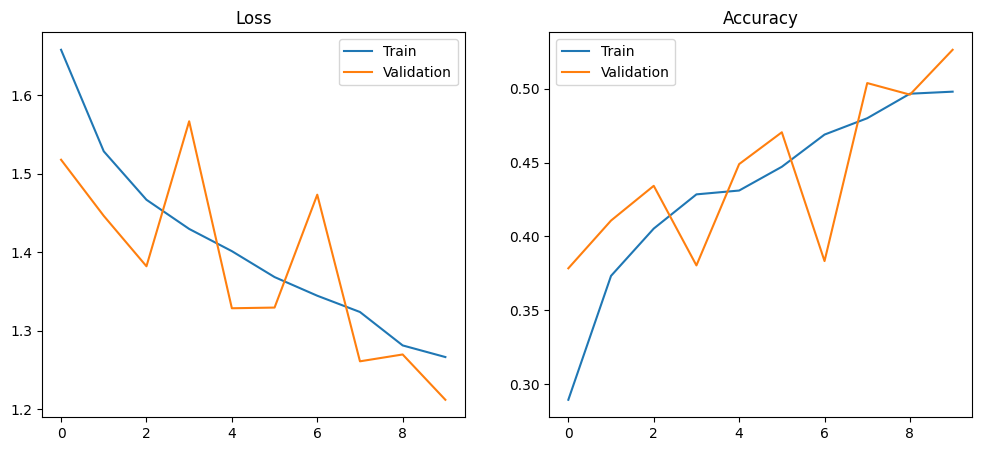

In [60]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['val_acc'], label='Validation')
plt.title('Accuracy')
plt.legend()

plt.savefig('training_history.png')
print("Training history plot saved to training_history.png")

In [62]:
# Function to initialize the transformer model
def initialize_transformer_model():
    print("Initializing transformer model...")
    
    try:
        # Get a batch from the train loader to determine input shape
        test_batch = next(iter(train_loader))
        input_data = test_batch[0]
        in_channels = input_data.shape[1]  # Get the channel dimension
        print(f"✓ Input shape detected: {input_data.shape}")
        
        # Initialize model with the correct number of input channels
        model = EmotionTransformer(
            num_classes=len(emotion_mapping), 
            in_channels=in_channels,
            dim=128,
            depth=4,
            heads=4,
            mlp_dim=256,
            dropout=0.4
        )
        model = model.to(device)
        
        # Print model summary
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Model has {total_params:,} parameters ({trainable_params:,} trainable)")
        
        return model
    except Exception as e:
        print(f"✗ Error initializing transformer model: {e}")
        traceback.print_exc()
        return None

In [63]:
# Training with improved settings for the transformer model
def train_transformer():
    # Initialize model
    model = initialize_transformer_model()
    if model is None:
        return
    
    # Loss function with label smoothing for better generalization
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    
    # Optimizer with weight decay for regularization
    optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)
    
    # Learning rate scheduler with warm-up and cosine annealing
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15, eta_min=1e-6)
    
    # Train and validate
    print("\nStarting transformer model training...")
    model, history = train_and_validate(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=15,  # More epochs for better convergence
        device=device,
        scheduler=scheduler
    )
    
    # Generate predictions for test set
    print("\nGenerating predictions with transformer model...")
    submission_df = predict(model, test_loader, device)
    submission_df.to_csv('transformer_submission.csv', index=False)
    print("Transformer predictions saved to transformer_submission.csv")
    
    return model, history

Initializing transformer model...
✓ Input shape detected: torch.Size([16, 20, 64, 100])
Model has 675,751 parameters (675,751 trainable)

Starting transformer model training...
Starting training loop...
Testing first batch load...
✓ First batch loaded successfully: torch.Size([16, 20, 64, 100])

Starting Epoch 1/15...
Training batches:
  Batch 10/362: loss=1.8477, acc=0.0625
  Batch 20/362: loss=1.6823, acc=0.2500
  Batch 30/362: loss=1.7142, acc=0.1875
  Batch 40/362: loss=1.7287, acc=0.1875
  Batch 50/362: loss=1.6962, acc=0.1875
  Batch 60/362: loss=1.8360, acc=0.2500
  Batch 70/362: loss=1.7140, acc=0.3125
  Batch 80/362: loss=1.5882, acc=0.3750
  Batch 90/362: loss=1.7313, acc=0.3750
  Batch 100/362: loss=1.5037, acc=0.5625
  Batch 110/362: loss=1.6947, acc=0.1875
  Batch 120/362: loss=1.6206, acc=0.3125
  Batch 130/362: loss=1.8709, acc=0.1875
  Batch 140/362: loss=1.5022, acc=0.5000
  Batch 150/362: loss=1.5363, acc=0.5000
  Batch 160/362: loss=1.4995, acc=0.5000
  Batch 170/362

Predicting:   0%|          | 0/107 [00:00<?, ?it/s]

Transformer predictions saved to transformer_submission.csv
Transformer training history plot saved to transformer_history.png


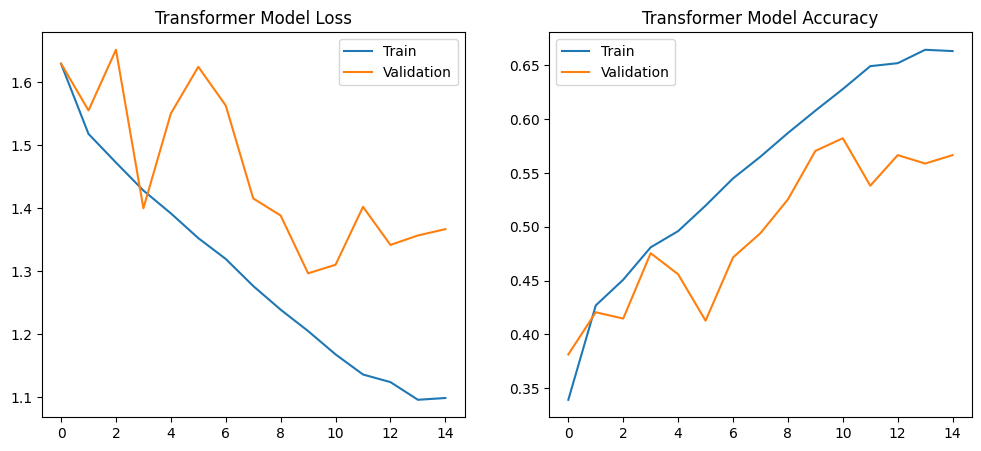

In [64]:
# Run the transformer model training
transformer_model, transformer_history = train_transformer()

# Plot transformer training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(transformer_history['train_loss'], label='Train')
plt.plot(transformer_history['val_loss'], label='Validation')
plt.title('Transformer Model Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(transformer_history['train_acc'], label='Train')
plt.plot(transformer_history['val_acc'], label='Validation')
plt.title('Transformer Model Accuracy')
plt.legend()

plt.savefig('transformer_history.png')
print("Transformer training history plot saved to transformer_history.png")